**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

**Importing cyberbullying_tweets dataset**

In [2]:
file=pd.read_csv('/content/cyberbullying_tweets.csv')

**Data preprocessing**

In [3]:
file.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [4]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


In [7]:
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import demoji
import string
import nltk

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Using NLP techniques for data preprocessing and data cleaning**

In [11]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will', 'wa', 'e', 'like'])
stemmer = SnowballStemmer('english')
def clean_text(text):
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    text = text.lower()
    text = " ".join([stemmer.stem(word) for word in text.split()])
    remove_punc = re.compile(r"[%s]" % re.escape(string.punctuation))
    text = remove_punc.sub('', text)
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    emoji = demoji.findall(text)
    for emot in emoji:
        text = re.sub(r"(%s)" % (emot), "_".join(emoji[emot].split()), text)

    return text

In [12]:
file['cleaned_text'] = file['tweet_text'].apply(lambda text: clean_text(text))

In [13]:
file.head()

,tweet_text,cyberbullying_type,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,whi white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,gio meh thank head concern anoth angri dude tw...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account islam lies


**Exploratory Data Analysis**

In [14]:
file.isnull().sum()

tweet_text            0
cyberbullying_type    0
cleaned_text          0
dtype: int64

In [15]:
file['cleaned_text'].duplicated().sum()

2887

In [16]:
file.drop_duplicates("cleaned_text", inplace = True)

In [17]:
file['cleaned_text'].str.isspace().sum() 

0

In [18]:
file = file[file["cyberbullying_type"]!="other_cyberbullying"]

In [19]:
file['cyberbullying_type'].value_counts()

religion             7946
age                  7887
ethnicity            7797
not_cyberbullying    7670
gender               7637
Name: cyberbullying_type, dtype: int64

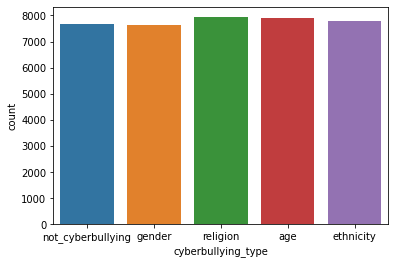

In [20]:
sns.countplot(data = file, x = 'cyberbullying_type')

Text(0, 0.5, 'Tweet Length')

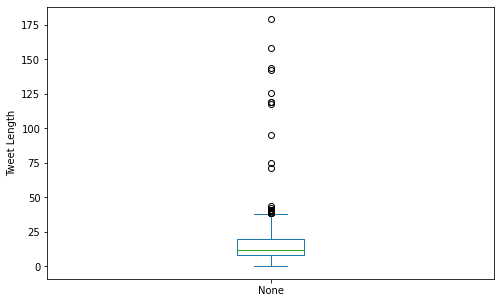

In [21]:
tweet_len = pd.Series([len(tweet.split())for tweet in file['cleaned_text']])
plt.figure(figsize=(8,5))
tweet_len.plot(kind="box")
plt.ylabel("Tweet Length")

**Data Visualization**

In [22]:
 for cyber_type in file.cyberbullying_type.unique():
    top50_word = file.cleaned_text[file.cyberbullying_type==cyber_type].str.split(expand=True).stack().value_counts()[:10]
    
    fig = px.bar(top50_word, color=top50_word.values, color_continuous_scale=px.colors.sequential.RdPu, custom_data=[top50_word.values])
    fig.update_traces(marker_color='blue')
    fig.update_traces(hovertemplate='<b>Count: </b>%{customdata[0]}')
    fig.update_layout(title=f"Top 10 words for {cyber_type}",
                     template='simple_white',
                     hovermode='x unified')
    fig.show()

**Testing and Training Data Split**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
X = file['cleaned_text'] 
y = file['cyberbullying_type']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

**TF-IDF Vectorization**

In [26]:
tfidf = TfidfVectorizer(max_features = 5000)

In [27]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)  

In [28]:
X_train_tfidf

<35043x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 403374 stored elements in Compressed Sparse Row format>

In [29]:
X_test_tfidf

<3894x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 44224 stored elements in Compressed Sparse Row format>

**Standardization**

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
tfidf_array_train = X_train_tfidf.toarray() 
tfidf_array_test = X_test_tfidf.toarray()    
scaled_X_train = scaler.fit_transform(tfidf_array_train)  
scaled_X_test = scaler.transform(tfidf_array_test) 

**Principal Component Analysis (PCA) for dimensionality reduction**

In [31]:
from sklearn.decomposition import PCA
NUM_COMPONENTS = 5000
pca = PCA(NUM_COMPONENTS)
reduced = pca.fit(scaled_X_train)

In [32]:
variance_explained = np.cumsum(pca.explained_variance_ratio_) 

Text(0, 0.5, 'Cumulative explained variance')

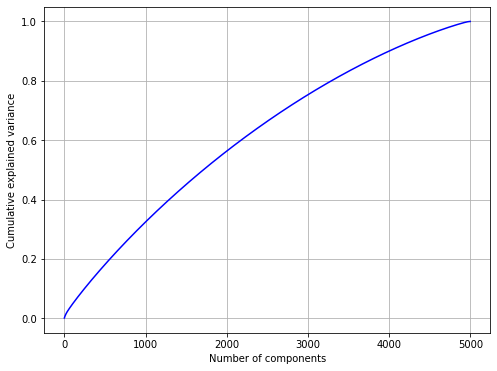

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(NUM_COMPONENTS),variance_explained, color='b')
ax.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")

In [34]:
final_pca = PCA(0.9)   
reduced_90 = final_pca.fit_transform(scaled_X_train)

In [35]:
reduced_90_test = final_pca.transform(scaled_X_test)
reduced_90.shape

(35043, 3999)

In [36]:
final_pca = PCA(0.8)
reduced_80 = final_pca.fit_transform(scaled_X_train)

In [37]:
reduced_80.shape

(35043, 3290)

**Training the model**

Logistic Regression

In [38]:
from sklearn.metrics import plot_confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



                   precision    recall  f1-score   support

              age       0.86      0.83      0.85       766
        ethnicity       0.90      0.85      0.87       801
           gender       0.77      0.79      0.78       788
not_cyberbullying       0.65      0.67      0.66       783
         religion       0.84      0.86      0.85       756

         accuracy                           0.80      3894
        macro avg       0.80      0.80      0.80      3894
     weighted avg       0.80      0.80      0.80      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



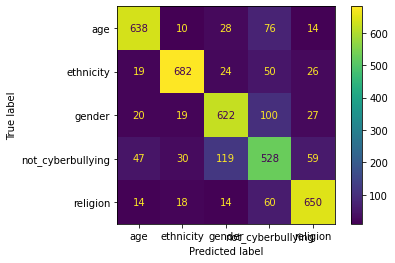

In [39]:
from sklearn.linear_model import LogisticRegression
log_model_pca = LogisticRegression()
log_model_pca.fit(reduced_90, y_train)
preds_log_model_pca = log_model_pca.predict(reduced_90_test)
print(classification_report(y_test, preds_log_model_pca))
plot_confusion_matrix(log_model_pca, reduced_90_test, y_test)

                   precision    recall  f1-score   support

              age       0.96      0.97      0.96       766
        ethnicity       0.98      0.98      0.98       801
           gender       0.92      0.84      0.88       788
not_cyberbullying       0.80      0.85      0.82       783
         religion       0.94      0.96      0.95       756

         accuracy                           0.92      3894
        macro avg       0.92      0.92      0.92      3894
     weighted avg       0.92      0.92      0.92      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



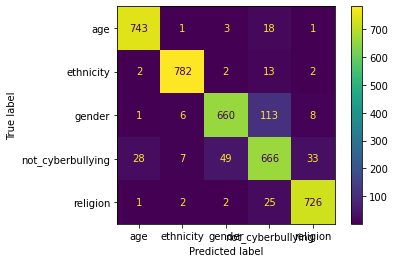

In [40]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
log_model = LogisticRegression(solver = 'saga')
param_grid = {'C': np.logspace(0, 10, 5)}
grid_log_model = HalvingGridSearchCV(log_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_log_model.fit(X_train_tfidf, y_train)
preds_grid_log_model = grid_log_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_log_model))
plot_confusion_matrix(grid_log_model, X_test_tfidf, y_test)

In [41]:
grid_log_model.best_estimator_

LogisticRegression(solver='saga')

Support Vector Machine

                   precision    recall  f1-score   support

              age       0.94      0.98      0.96       766
        ethnicity       0.97      0.98      0.98       801
           gender       0.94      0.81      0.87       788
not_cyberbullying       0.79      0.85      0.82       783
         religion       0.95      0.96      0.96       756

         accuracy                           0.92      3894
        macro avg       0.92      0.92      0.92      3894
     weighted avg       0.92      0.92      0.92      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



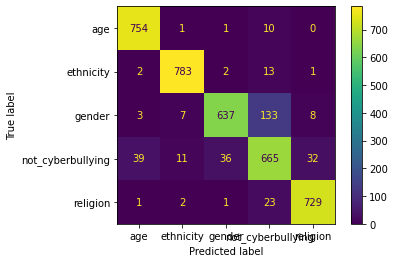

In [42]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
C = [1e-5, 1e-4, 1e-2, 1e-1, 1]
param_grid = {'C': C}
grid_svm_model = HalvingGridSearchCV(svm_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_svm_model.fit(X_train_tfidf, y_train)
preds_grid_svm_model = grid_svm_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_svm_model))
plot_confusion_matrix(grid_svm_model, X_test_tfidf, y_test)

In [43]:
grid_svm_model.best_estimator_

LinearSVC(C=0.1)

Neural Networks

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



                   precision    recall  f1-score   support

              age       0.96      0.95      0.96       766
        ethnicity       0.97      0.97      0.97       801
           gender       0.89      0.85      0.87       788
not_cyberbullying       0.80      0.83      0.81       783
         religion       0.94      0.95      0.95       756

         accuracy                           0.91      3894
        macro avg       0.91      0.91      0.91      3894
     weighted avg       0.91      0.91      0.91      3894



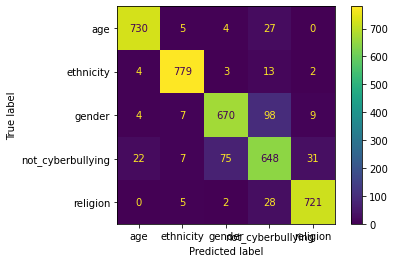

In [44]:
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(activation = 'logistic', max_iter = 10)
param_grid = {'learning_rate_init': [0.001, 0.0015, 0.002, 0.0025]}
grid_nn_model = HalvingGridSearchCV(nn_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_nn_model.fit(X_train_tfidf, y_train)
preds_grid_nn_model = grid_nn_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_nn_model))
plot_confusion_matrix(grid_nn_model, X_test_tfidf, y_test)

In [45]:
grid_nn_model.best_estimator_

MLPClassifier(activation='logistic', learning_rate_init=0.002, max_iter=10)

Random Forest Classifier

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98       766
        ethnicity       0.98      0.98      0.98       801
           gender       0.92      0.86      0.89       788
not_cyberbullying       0.81      0.86      0.84       783
         religion       0.95      0.96      0.96       756

         accuracy                           0.93      3894
        macro avg       0.93      0.93      0.93      3894
     weighted avg       0.93      0.93      0.93      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



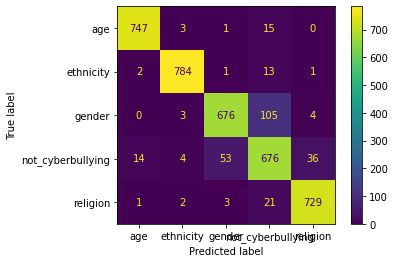

In [46]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state = 42)
n_estimators = [64, 100, 128]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators, 'bootstrap': bootstrap}
grid_rf_model = HalvingGridSearchCV(rf_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_rf_model.fit(X_train_tfidf, y_train)
preds_grid_rf_model = grid_rf_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_rf_model))
plot_confusion_matrix(grid_rf_model, X_test_tfidf, y_test)

In [47]:
grid_rf_model.best_estimator_

RandomForestClassifier(n_estimators=128, random_state=42)

Gradient Boosting

                   precision    recall  f1-score   support

              age       0.98      0.97      0.98       766
        ethnicity       0.99      0.98      0.99       801
           gender       0.95      0.79      0.86       788
not_cyberbullying       0.75      0.91      0.82       783
         religion       0.96      0.95      0.95       756

         accuracy                           0.92      3894
        macro avg       0.93      0.92      0.92      3894
     weighted avg       0.93      0.92      0.92      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



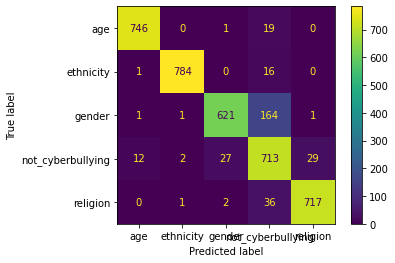

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
grad_model = GradientBoostingClassifier(random_state = 42)
param_grid = {'n_estimators': [64, 100, 128, 200]}
grid_grad_model = HalvingGridSearchCV(grad_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_grad_model.fit(X_train_tfidf, y_train)
preds_grid_grad_model = grid_grad_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_grad_model))
plot_confusion_matrix(grid_grad_model, X_test_tfidf, y_test)

In [49]:
grid_grad_model.best_estimator_

GradientBoostingClassifier(n_estimators=200, random_state=42)

ADA boost

                   precision    recall  f1-score   support

              age       0.98      0.95      0.96       766
        ethnicity       0.98      0.97      0.97       801
           gender       0.95      0.77      0.85       788
not_cyberbullying       0.73      0.89      0.80       783
         religion       0.93      0.94      0.94       756

         accuracy                           0.90      3894
        macro avg       0.91      0.90      0.90      3894
     weighted avg       0.91      0.90      0.90      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



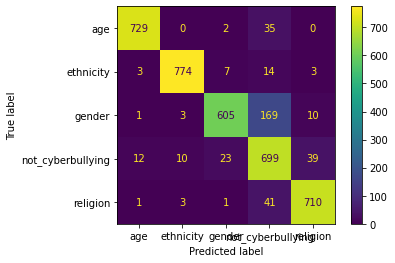

In [50]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
ada_model= AdaBoostClassifier(random_state = 42)
param_grid = {'n_estimators': [64, 100, 128, 200]}
grid_ada_model = HalvingGridSearchCV(ada_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_ada_model.fit(X_train_tfidf, y_train)
preds_grid_ada_model = grid_ada_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_ada_model))
plot_confusion_matrix(grid_ada_model, X_test_tfidf, y_test)


In [51]:
grid_ada_model.best_estimator_

AdaBoostClassifier(n_estimators=100, random_state=42)

XGB Classifier

In [52]:
from xgboost import XGBClassifier

                   precision    recall  f1-score   support

              age       0.98      0.98      0.98       766
        ethnicity       0.99      0.98      0.99       801
           gender       0.96      0.79      0.87       788
not_cyberbullying       0.74      0.92      0.82       783
         religion       0.96      0.94      0.95       756

         accuracy                           0.92      3894
        macro avg       0.93      0.92      0.92      3894
     weighted avg       0.93      0.92      0.92      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



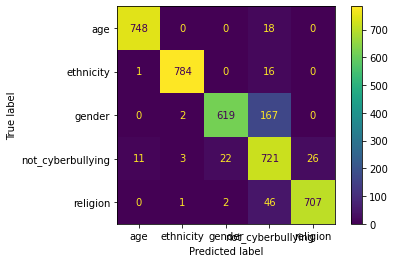

In [53]:
xg_model= XGBClassifier(random_state = 42)
param_grid = {'n_estimators': [64, 100, 128, 200]}
grid_xg_model = HalvingGridSearchCV(xg_model, param_grid = param_grid, n_jobs = -1, min_resources = 'exhaust', factor = 3)
grid_xg_model.fit(X_train_tfidf, y_train)
preds_grid_xg_model = grid_xg_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_grid_xg_model))
plot_confusion_matrix(grid_xg_model, X_test_tfidf, y_test)

In [54]:
grid_xg_model.best_estimator_

XGBClassifier(n_estimators=200, objective='multi:softprob', random_state=42)

Multinomial Naive Bayes

                   precision    recall  f1-score   support

              age       0.81      0.97      0.88       766
        ethnicity       0.88      0.91      0.90       801
           gender       0.86      0.80      0.83       788
not_cyberbullying       0.83      0.55      0.66       783
         religion       0.81      0.96      0.88       756

         accuracy                           0.84      3894
        macro avg       0.84      0.84      0.83      3894
     weighted avg       0.84      0.84      0.83      3894



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



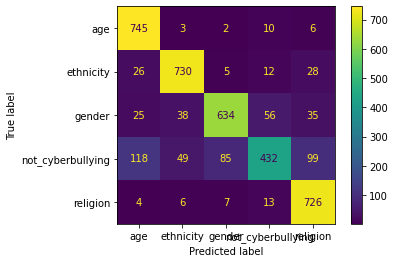

In [55]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
preds_nb_model = nb_model.predict(X_test_tfidf)
print(classification_report(y_test, preds_nb_model))
plot_confusion_matrix(nb_model, X_test_tfidf, y_test)

**Pipeline creation**

In [56]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer(max_features = 5000)), ('rf_model', RandomForestClassifier(n_estimators = 128, random_state = 42))])
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('rf_model',
                 RandomForestClassifier(n_estimators=128, random_state=42))])

**Demonstration of the working model**

**NOTE: I am strongly against the cyberbullying happenings in social media. The words below contains some offensive comments made by users in Twitter just to show the working of the model. I don't support any of the comments and they were chosen just for the implementation.**

In [57]:
pipe.predict(["Fuck You Danish hater! Fuck you arsehole muslim lover. Muslims control you. you are a slave to them. Denmark is a great country."])

array(['religion'], dtype=object)

In [60]:
pipe.predict([" I'll rape your fucking family if you don't leave you semite bastard. I will shoot you if you return, because you're a dirty semite gay, I hope you choke on a fucking bagel, prick. Shalom.  "])

array(['gender'], dtype=object)

In [61]:
pipe.predict(["It was a pretty hard day at school, sometimes its too stressful ahhh"])

array(['not_cyberbullying'], dtype=object)

In [62]:
pipe.predict(["ANOUNCEMENT: I AM MAD AT THE PEOPLE WHO BAN ME FOR THINGS I DON``T DO SO ALL MEXICANS AND   BLACK PEOPLE ARE SHIT HEADS AND IM IN THE KKK FUCK HEADS!!!!!!1"])

array(['ethnicity'], dtype=object)

In [68]:
pipe.predict(["Your moms a whore.. xoxo"])

array(['gender'], dtype=object)

In [69]:
pipe.predict(["Dumb ass nigga.  No one cares when your birthday is.  Jag quimby sounds gay as shit.  Your name sounds like you're the son of that mayor from the simpsons.  Jaq quimby....nigga you need to change your name to jaq off.  "])

array(['ethnicity'], dtype=object)